In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import ray

from multi_run.backtest_v2 import simulate_strategy
from multi_run.initialize_v2 import data_pp, screener, make_weekly_momentum_mask

2023-05-11 21:17:30,549	INFO worker.py:1625 -- Started a local Ray instance.


In [4]:
cmktcap = pd.read_pickle("Data/cmktcap_data_final.pickle")
#cmkt_data = data_pp(cmktcap, vender="coinmarketcap")

binance = pd.read_pickle("Data/binance_data_pp.pickle")
cmkt_data = data_pp(binance, vender="binance")

In [5]:
rtn = cmkt_data["price"].pct_change(fill_method=None)

In [6]:
mask = screener(cmkt_data["mktcap"],
                cmkt_data["vol"],
                1_000_000,
                1_000_000)

In [41]:
mask.index

DatetimeIndex(['2013-05-06', '2013-05-07', '2013-05-08', '2013-05-09',
               '2013-05-10', '2013-05-11', '2013-05-12', '2013-05-13',
               '2013-05-14', '2013-05-15',
               ...
               '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-01',
               '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05',
               '2023-04-06', '2023-04-07'],
              dtype='datetime64[ns]', name='date', length=3624, freq=None)

In [14]:
mask_sample = mask.resample("W").last().loc["2017-12-31":]
mask_sample

permno,1INCH,AAVE,ACH,ADA,AGIX,AKRO,ALGO,ALICE,ALPHA,AMB,...,XLM,XMR,XRP,XTZ,YFI,YFII,ZEC,ZEN,ZIL,ZRX
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
2018-01-07,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
2018-01-14,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
2018-01-21,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
2018-01-28,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0
2023-03-19,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0
2023-03-26,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0


In [15]:
weekly_rtn = cmkt_data["price"].pct_change(7, fill_method=None).resample("W").last().loc["2017-12-31":]
weekly_rtn

permno,1INCH,AAVE,ACH,ADA,AGIX,AKRO,ALGO,ALICE,ALPHA,AMB,...,XLM,XMR,XRP,XTZ,YFI,YFII,ZEC,ZEN,ZIL,ZRX
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,0.845234,NaN,NaN,NaN,NaN,NaN,NaN,...,0.607288,0.035501,1.203723,0.015141,NaN,NaN,-0.050687,0.356823,NaN,0.425263
2018-01-07,NaN,NaN,NaN,0.401314,NaN,NaN,NaN,NaN,NaN,NaN,...,0.939388,0.316038,0.468253,0.333355,NaN,NaN,0.742319,-0.124598,NaN,0.522315
2018-01-14,NaN,NaN,NaN,-0.204515,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.098320,-0.130216,-0.448995,0.020585,NaN,NaN,-0.232759,0.015853,NaN,0.464152
2018-01-21,NaN,NaN,NaN,-0.235707,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.264306,-0.136263,-0.258518,-0.174136,NaN,NaN,-0.279299,-0.291993,NaN,-0.142279
2018-01-28,NaN,NaN,NaN,0.093162,NaN,NaN,NaN,NaN,NaN,NaN,...,0.366943,-0.037417,0.014177,-0.001383,NaN,NaN,-0.030862,0.311644,NaN,0.156388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,-0.074197,-0.028196,-0.095889,-0.016500,-0.186535,NaN,-0.109143,-0.068606,-0.004711,-0.176036,...,0.003789,0.009162,0.016679,-0.056021,-0.190149,NaN,-0.097035,-0.080388,-0.111466,-0.102153
2023-03-19,0.159203,0.090853,0.419976,0.043646,0.360405,NaN,0.092036,0.119521,0.115988,-0.050007,...,0.058544,0.018470,0.040573,0.178036,0.062614,NaN,0.064877,0.089997,0.199002,0.169661
2023-03-26,-0.070742,-0.083865,-0.186470,0.029582,-0.132211,NaN,-0.046098,-0.100573,-0.099318,-0.133784,...,0.045862,0.051236,0.155361,-0.084100,-0.042441,NaN,-0.009893,-0.040279,-0.068833,-0.082495


In [12]:
r = (weekly_rtn *  mask)

In [13]:
# Pandas 방식대로 하면 이 개수가 나와야 한다
r.sum(1).loc["2017-12-31":].resample("W").last()#.plot()

date
2017-12-31     7.568457
2018-01-07    28.053983
2018-01-14    -3.951574
2018-01-21    -8.842862
2018-01-28     2.768752
                ...    
2023-03-12   -10.321496
2023-03-19    25.546455
2023-03-26   -10.503758
2023-04-02     3.703732
2023-04-09     0.000000
Freq: W-SUN, Length: 276, dtype: float64

In [17]:
w_mask = make_weekly_momentum_mask(cmkt_data["price"],
                                   cmkt_data["mktcap"],
                                   cmkt_data["vol"],
                                   n_group=5,
                                   day_of_week="SUN",
                                   number_of_coin_group=20,
                                   mktcap_thresh=1_000_000,
                                   vol_thresh=1_000_000)

In [19]:
w_mask.keys()

dict_keys(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

In [37]:
mktcap_df = cmkt_data["mktcap"]
mktcap_df_sample = mktcap_df.resample("W").last().loc["2021-12-03":]

In [38]:
weight = (w_mask["Q5"] * mktcap_df_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [39]:
weight.sum(1)

date
2020-10-11    0.0
2020-10-18    0.0
2020-10-25    0.0
2020-11-01    0.0
2020-11-08    0.0
             ... 
2023-03-12    1.0
2023-03-19    1.0
2023-03-26    1.0
2023-04-02    1.0
2023-04-09    1.0
Freq: W-SUN, Length: 131, dtype: float64

In [30]:
rt = simulate_strategy(weight, rtn, fee_rate=0.0015)

In [31]:
rt

2018-12-09    0.0
2018-12-10   -1.0
2018-12-11    0.0
2018-12-12    0.0
2018-12-13    0.0
             ... 
2023-04-03    0.0
2023-04-04    0.0
2023-04-05    0.0
2023-04-06    0.0
2023-04-07    0.0
Length: 1581, dtype: float64

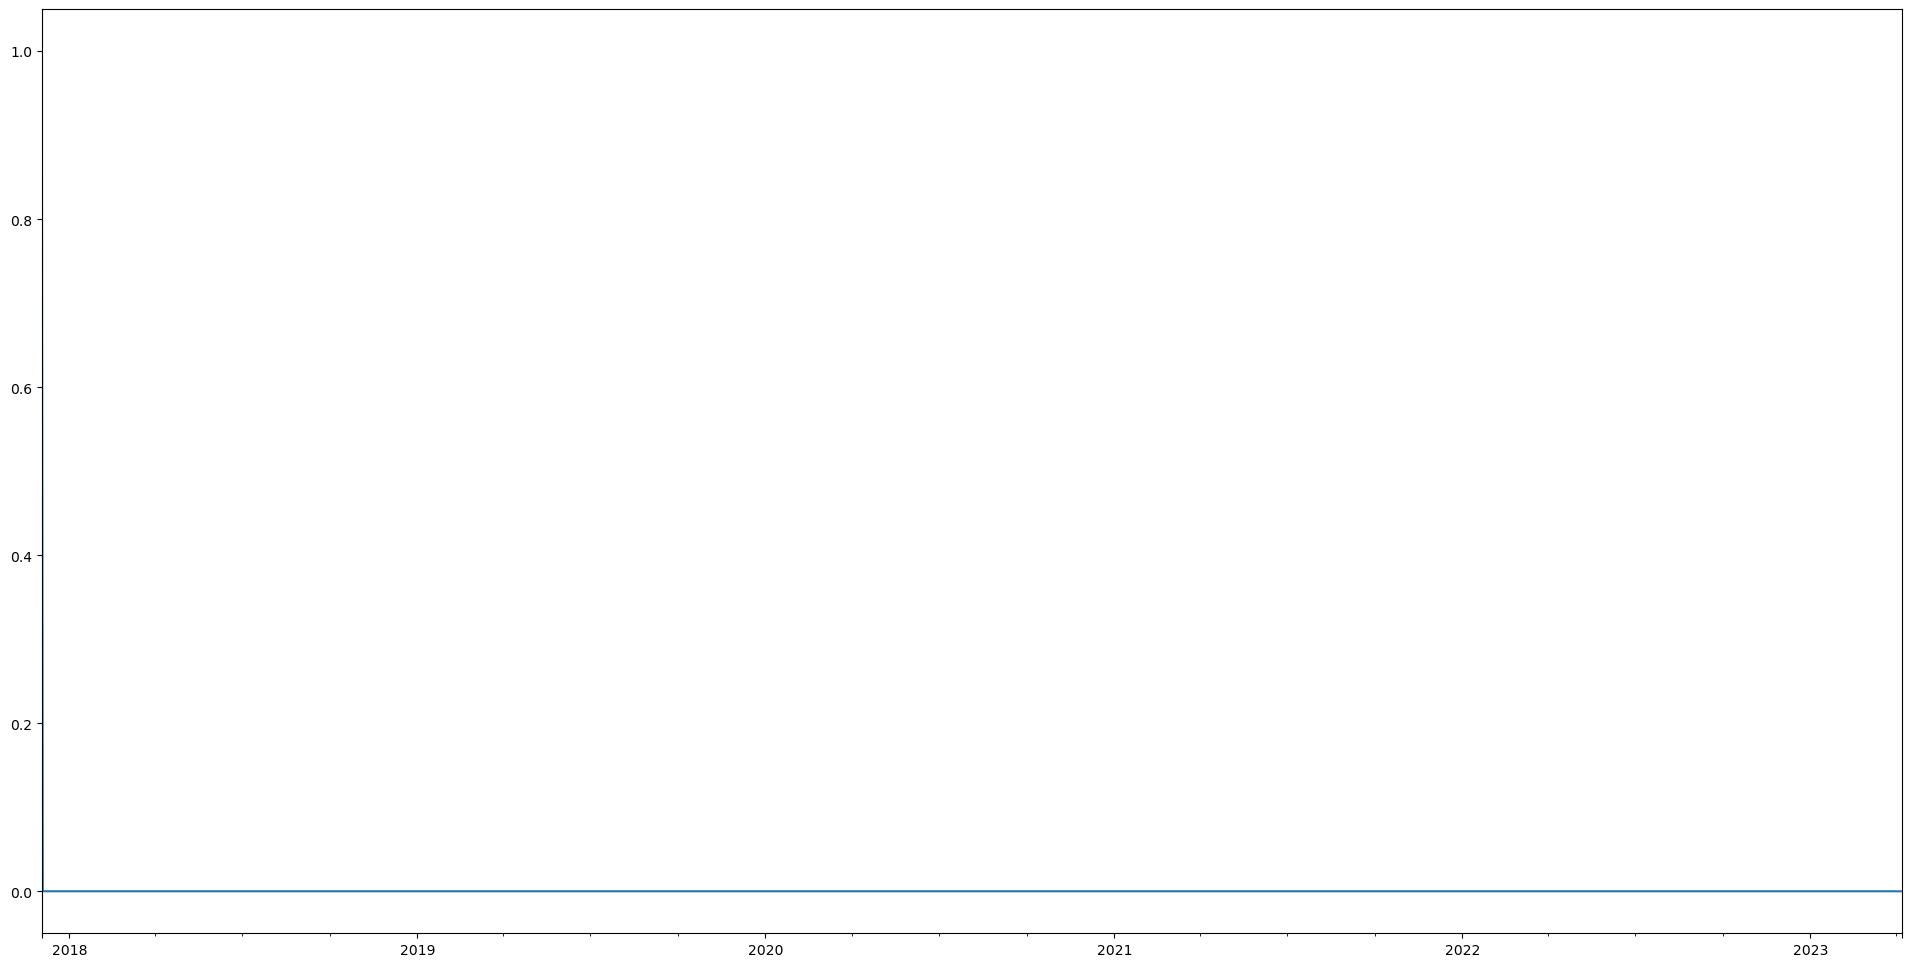

In [23]:
(rt+1).cumprod().plot(figsize=(24,12));

In [ ]:
q1 = w_mask["Q1"].sum(1)
q2 = w_mask["Q2"].sum(1)
q3 = w_mask["Q3"].sum(1)
q4 = w_mask["Q4"].sum(1)
q5 = w_mask["Q5"].sum(1)

pd.concat([q1,q2,q3,q4,q5], axis=1).sum(1).loc["2017-12-31":]#plot()

마켓 시뮬레이션

In [55]:
mktcap_pp = (cmkt_data["mktcap"][cmkt_data["mktcap"] > 1_000_000]) 
weight = mktcap_pp.apply(lambda x: x/np.nansum(x), axis=1).dropna(thresh=1)

In [56]:
mkt = simulate_strategy(group_weight_df=weight,
                        daily_rtn_df=rtn,
                        fee_rate=0)

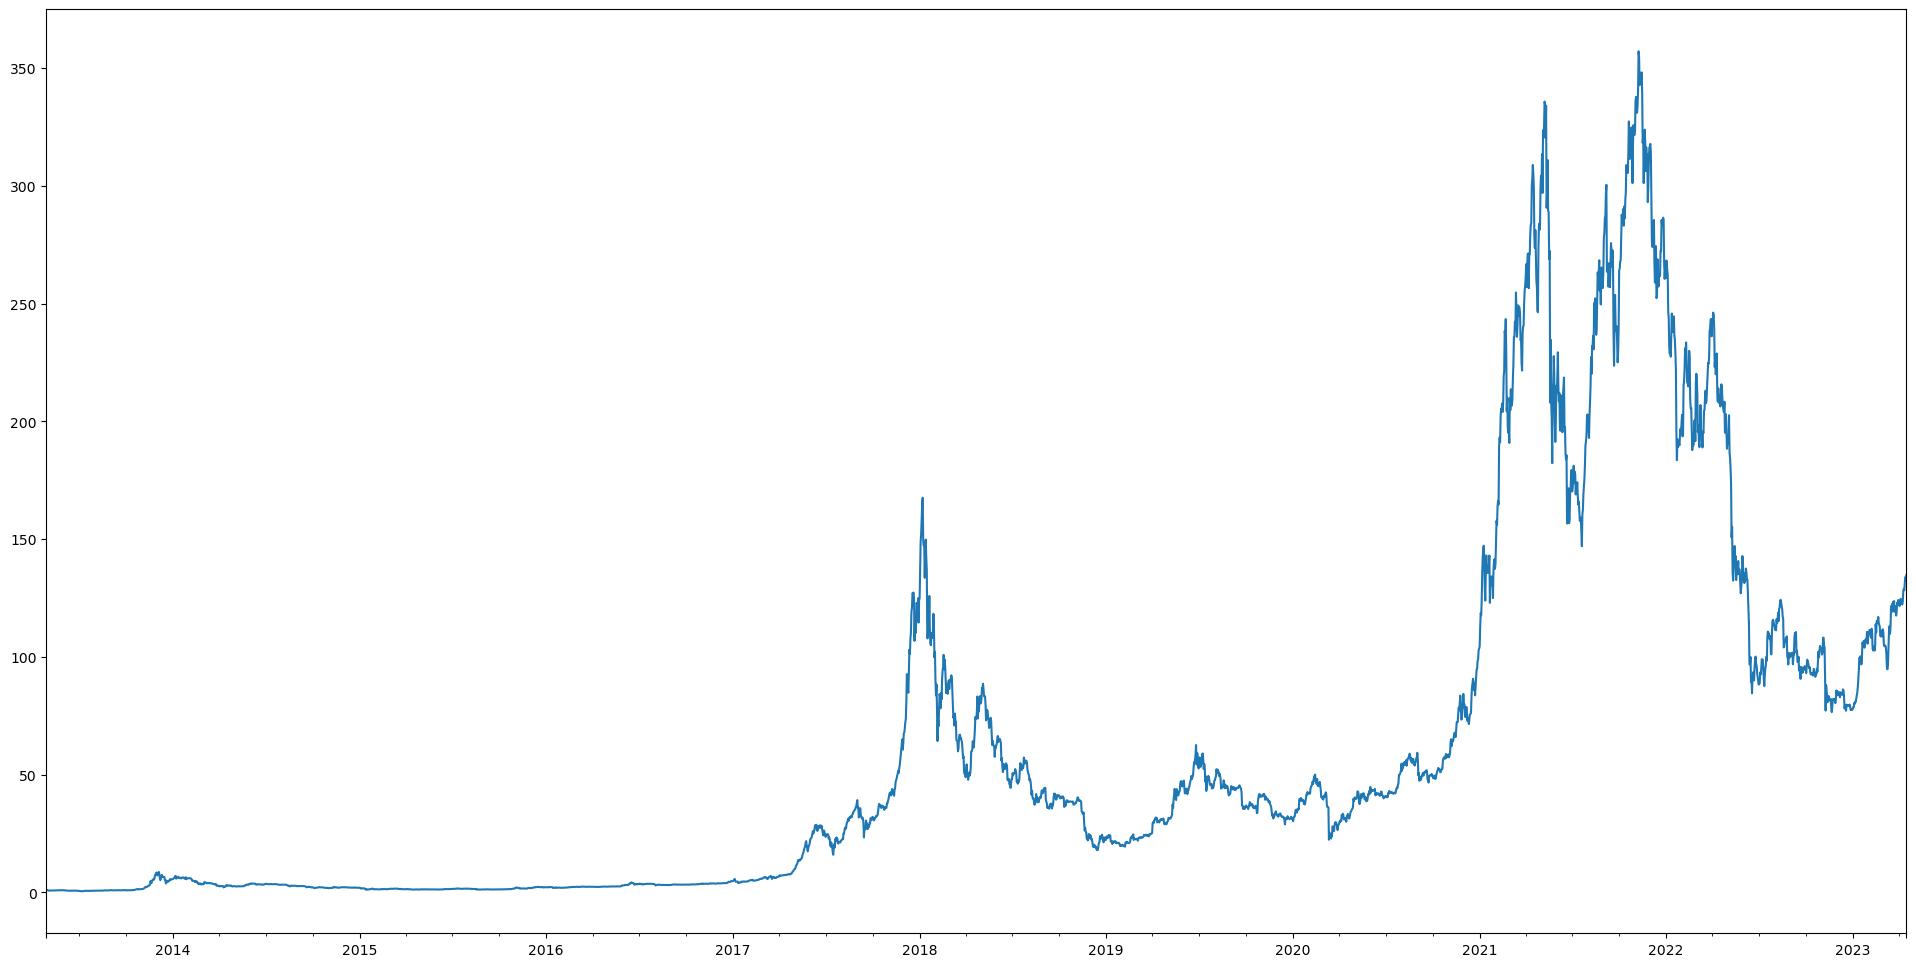

In [58]:
(mkt+1).cumprod().plot(figsize=(24,12));